In [1]:
import os
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
CLASSES = ['pedestrian', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign']

LABELS_DIR = "data/labels/train"  # <- Zmień jeśli masz inną ścieżkę

# Liczenie klas
class_counts = Counter()

In [3]:
for file in os.listdir(LABELS_DIR):
    if not file.endswith(".txt"):
        continue
    with open(os.path.join(LABELS_DIR, file)) as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            class_counts[class_id] += 1

counts_named = {CLASSES[k]: v for k, v in class_counts.items()}

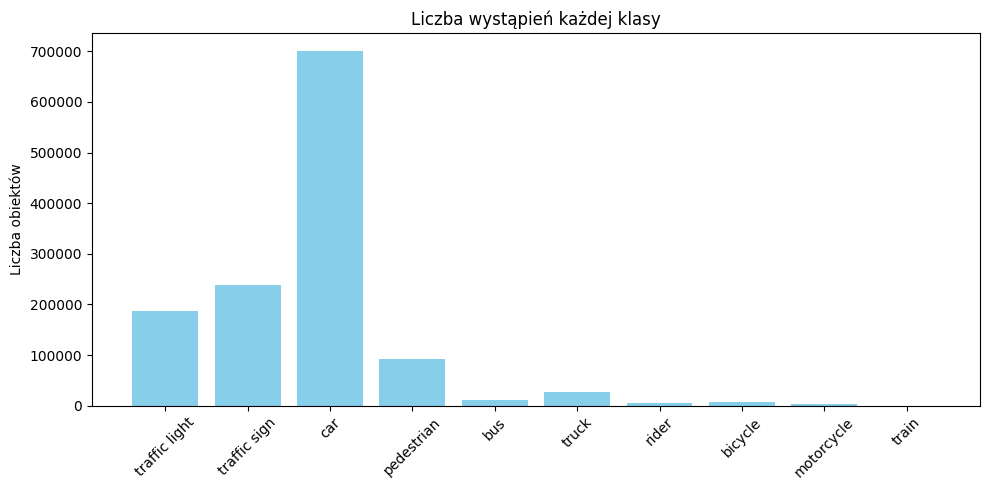

In [5]:
#  Wykres słupkowy
plt.figure(figsize=(10, 5))
plt.bar(counts_named.keys(), counts_named.values(), color='skyblue')
plt.title("Liczba wystąpień każdej klasy")
plt.ylabel("Liczba obiektów")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
def clip_bbox(bbox):
    x, y, w, h = bbox
    x = min(max(x, 0.0), 1.0)
    y = min(max(y, 0.0), 1.0)
    w = min(max(w, 0.0), 1.0)
    h = min(max(h, 0.0), 1.0)
    return [x, y, w, h]

def safe_clip_yolo_box(box):
    x, y, w, h = box
    x = min(max(x, 0.0), 1.0)
    y = min(max(y, 0.0), 1.0)
    w = min(max(w, 0.0), 1.0)
    h = min(max(h, 0.0), 1.0)
    return [x, y, w, h]

def cut(x):
    return max(0, min(1, x))

In [37]:
import os
import cv2
import random
from pathlib import Path
from albumentations import (
    HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate,
    Resize, Compose, Affine
)
from albumentations.pytorch import ToTensorV2

# Ustawienia
input_images = Path("data/images/train")
input_labels = Path("data/labels/train")
output_images = Path("augmented/images")
output_labels = Path("augmented/labels")
os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

classes = ['pedestrian', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign']
rare_classes = {'bus'}

# Augmentacje do zastosowania
transform = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.3),
    Affine(translate_percent=(-0.05, 0.05), scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),
], bbox_params={
    "format": "yolo",
    "label_fields": ["class_labels"],
    "check_each_transform": False,
    "min_visibility": 0
})

# Przetwarzanie plików
for label_path in input_labels.glob("*.txt"):
    with open(label_path, "r") as f:
        lines = f.readlines()

    boxes, class_labels = [], []
    contains_rare = False

    for line in lines:
        cls_id, x, y, w, h = map(float, line.strip().split())

        print(x)
        class_name = classes[int(cls_id)]
        box = [x, y, w, h]

        # Walidacja
        if all(0.0 <= v <= 1.0 for v in box):
            boxes.append(box)
            class_labels.append(class_name)
            if class_name in rare_classes:
                contains_rare = True

    if not contains_rare:
        continue

    img_path = input_images / (label_path.stem + ".jpg")
    image = cv2.imread(str(img_path))

    # Augmentacja
    for i in range(3):  # 3 augmentacje na obraz
        cleaned_boxes = [safe_clip_yolo_box(b) for b in boxes]
        augmented = transform(image=image, bboxes=cleaned_boxes, class_labels=class_labels)
        aug_img = augmented["image"]
        aug_bboxes = augmented["bboxes"]
        aug_labels = augmented["class_labels"]

        # Zapisz obraz
        out_img_path = output_images / f"{label_path.stem}_aug{i}.jpg"
        cv2.imwrite(str(out_img_path), aug_img)

        # Zapisz label
        out_lbl_path = output_labels / f"{label_path.stem}_aug{i}.txt"
        with open(out_lbl_path, "w") as out_f:
            for box, cls in zip(aug_bboxes, aug_labels):
                cls_id = classes.index(cls)
                out_f.write(f"{cls_id} {' '.join(map(str, box))}\n")


0.892141
0.917768
0.889633
0.039602
0.159473
0.553592
0.040459
0.218607
0.16744
0.727567
0.335287
0.444794
0.51748
0.478226
0.555352
0.580288
0.634798
0.663793
0.754025
0.943071
0.440346
0.425611
0.387384
0.392476
0.435352
0.451883
0.410384
0.471857
0.359243
0.343229
0.259579
0.304141
0.229617
0.43003
0.388375
0.550499
0.414946
0.486569
0.419541
0.600259
0.472721
0.424275
0.436759
0.449673
0.468615
0.481529
0.329138
0.094523
0.12724
0.388114
0.495018
0.885468
0.427831
0.468876
0.215133
0.496708
0.510163
0.527714
0.989824
0.964588
0.931323
0.899969
0.725611
0.878623
0.042192
0.547662
0.534058
0.520804
0.50716
0.488839
0.593311
0.294317
0.378909
0.432314
0.398696
0.415942
0.444789
0.384366
0.484161
0.457263
0.475974
0.411654
0.732282
0.106812
0.151252
0.210115
0.634888
0.570422
0.474375
0.569922
0.522899
0.473374
0.434355
0.380328
0.407497
0.54591
0.588431
0.609942
0.64746
0.744508
0.920473
0.483552
0.480928
0.523949
0.09974
0.477927
0.487931
0.38338
0.094237
0.029705
0.267823
0.442909
0

ValueError: Expected x_max for bbox [0.9663105 0.550604  1.0003575 0.633564  1.       ] to be in the range [0.0, 1.0], got 1.0003575086593628.